In [165]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to a fixed size
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
# ])

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to a fixed size
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize for grayscale images
])



In [166]:
dataset_path = './dataset'

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [167]:
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [168]:
batch_size = 32  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [169]:
next(iter(train_loader))[0].shape,next(iter(train_loader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

CAPSULE NETWORK

In [141]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import pdb
from torch import nn
import math
from torch.optim import lr_scheduler
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
import seaborn as sns
# sns.set(style="darkgrid")
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST
from tqdm import tqdm
from torchvision import models
import torch.optim as optim
import torchvision
from matplotlib.ticker import MaxNLocator
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
!pip install torchsummary
from torchsummary import summary
# import chainer.links as L
# from PIL import Image
# from sklearn.model_selection import train_test_split
# import warnings
# warnings.filterwarnings("ignore")
plt.ion()

In [170]:
class CapsuleLevel(nn.Module):
    def __init__(self, in_channels, out_channels, capsule_dimension = 8, num_capsules = 10, num_capsule_units = 6 * 6 * 32, routing = False, iterations=3):
        super(CapsuleLevel, self).__init__()
        self.routing = routing
        self.iterations = iterations
        self.num_capsules = num_capsules
        self.num_capsule_units = num_capsule_units
        if routing == True:
            self.route_weights = nn.Parameter(torch.randn(num_capsule_units, num_capsules, out_channels, in_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=(9, 9), stride=(2, 2), padding=0) for _ in
                 range(capsule_dimension)])

            
    # The squash function
    def squash(self, s, dim=-1):
        norm = torch.sum(s**2, dim=dim, keepdim=True)
        return norm / (1 + norm) * s / (torch.sqrt(norm) + 1e-8)

    def forward(self, x):
        if self.routing == True:          # Routing by Agreement
            batch_size = x.size(0)
            
            route_weights = torch.stack([self.route_weights] * batch_size, dim = 0) #dim:([1152, 10, 16, 8])
            x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4) #dim:([128, 1152, 10, 8, 1])
            u_hat = torch.matmul(self.route_weights, x)  #dim:([128, 1152, 10, 16, 1])
            u_hat = u_hat.squeeze(-1)   #dim([128, 1152, 10, 16])
            temp_u_hat = u_hat.detach()
            
            #b_ij dim:([128, 1152, 10, 1])
            b_ij = Variable(torch.zeros(batch_size, self.num_capsule_units, self.num_capsules, 1)) 
            for iteration in range(self.iterations):
                c_ij = F.softmax(b_ij, dim=1)   # Equation 1 # c_ij dim:([128, 1152, 10, 1])
                s_ij = (c_ij * temp_u_hat).sum(dim=1)  # Equation 2 # s_ij dim:([128, 10, 16])
                temp_u_hat = temp_u_hat.unsqueeze(3)  # temp_u_hat dim:([128, 1152, 10, 16, 1])
                v_j = self.squash(s_ij, dim=2) # Equation 3  # v_j dim:([128, 10, 16])
                v_j_i = torch.stack([v_j] * self.num_capsule_units, dim = 1).unsqueeze(-1) # v_j_i dim:([128, 10, 16, 1])
                v_j_i = torch.matmul(temp_u_hat, v_j_i).squeeze(3)  
                temp_u_hat = temp_u_hat.squeeze(3)
                b_ij = b_ij + v_j_i # Equation 4
        else:
            v_j = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]   
            v_j = torch.cat(v_j, dim=-1)
            v_j = self.squash(v_j)

        return v_j

In [171]:
class CapsuleNetwork(nn.Module):  
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(9, 9), stride=(1, 1), padding=0)
        self.primaryCaps = CapsuleLevel(in_channels=256, out_channels=32, capsule_dimension=8)
        self.digitCaps   = CapsuleLevel(in_channels=8, out_channels=16, num_capsules=10, routing=True)
        self.decoder     = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # Get most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(10)).index_select(dim=0, index=Variable(max_length_indices.data))
        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return classes, reconstructions

In [172]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, img, target, classes, reconstructions):
        fn_1 = F.relu(0.9 - classes, inplace=True) ** 2  # Calculated for correct digit cap
        fn_2 = F.relu(classes - 0.1, inplace=True) ** 2  # Calculated for incorrect digit cap
        margin_loss = target * fn_1 + 0.5 * (1. - target) * fn_2
        margin_loss = margin_loss.sum()
        img = img.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, img)
        return (margin_loss + 0.0005 * reconstruction_loss) / img.size(0)

In [173]:
train_loss = []
test_loss = []
def train(train_loader, epoch):
    global model
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        labels = target
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        capsule_loss = LossFunction()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels)
        optimizer.zero_grad()
        classes, reconstructions = model(data, labels)
        loss = capsule_loss(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        pred = classes.data.max(1, keepdim=True)[1]
        if (batch_idx + 1)% 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [174]:
def evaluate(data_loader):
    global model
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        labels = target
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels)
        classes, reconstructions = model(data)
        capsule_loss = LossFunction()
        loss += capsule_loss(data, labels, classes, reconstructions).item()
        pred = classes.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    test_loss.append(loss)
    print('\nAverage Validation loss: {:.6f}\n'.format(loss))

In [175]:
model = CapsuleNetwork().to("cpu")
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 15
for epoch in range(n_epochs):
    train(train_loader, epoch)  #Training the model
    evaluate(test_loader)  #evaluating the model

/var/folders/54/xgnbdltd7nv2m8wttl50p87m0000gn/T/ipykernel_44219/2184545250.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Average Validation loss: 0.026670


Average Validation loss: 0.026586


Average Validation loss: 0.026583


Average Validation loss: 0.026575


Average Validation loss: 0.026573


Average Validation loss: 0.026576


Average Validation loss: 0.026571


Average Validation loss: 0.026619


Average Validation loss: 0.026570


Average Validation loss: 0.026571


Average Validation loss: 0.026573


Average Validation loss: 0.026573


Average Validation loss: 0.026572


Average Validation loss: 0.026585


Average Validation loss: 0.026587



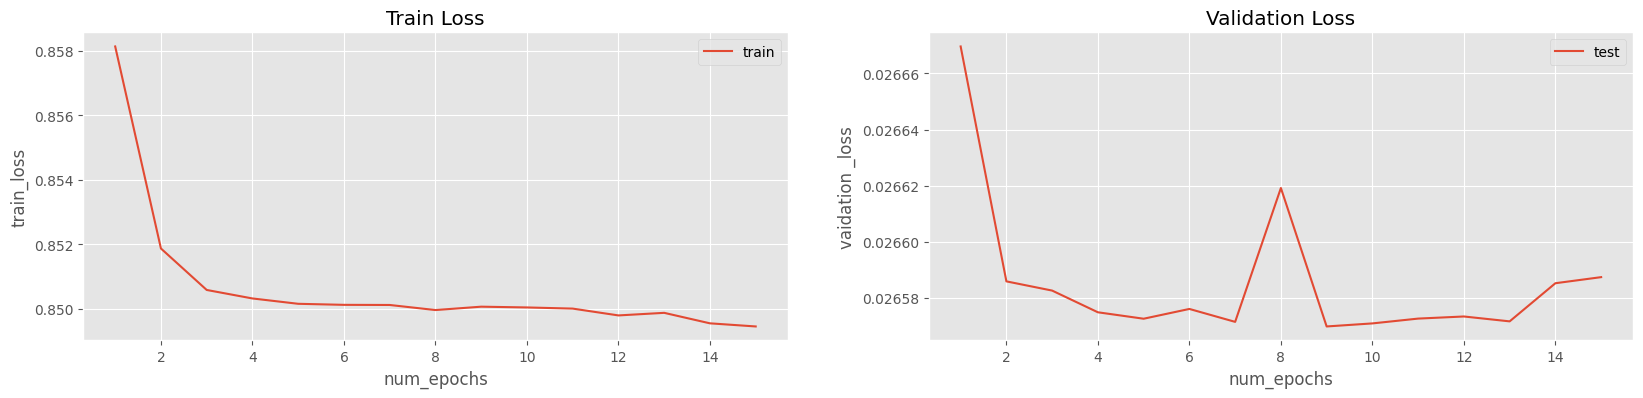

In [176]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(list(np.arange(15) + 1) , train_loss, label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('train_loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')
ax = fig.add_subplot(1, 2, 2)
plt.title("Validation Loss")
plt.plot(list(np.arange(15) + 1), test_loss, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('vaidation _loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')


In [178]:
n_epochs

15